# Synoptic Analysis

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pkg_resources
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
from dk_met_io.retrieve_micaps_server import get_model_grid
from dk_met_graphics.plot.china_map import add_china_map_2cartopy
from dk_met_graphics.color_maps import guide_cmaps, ncl_cmaps

## 亚欧区域形势场, 500hPa高度场,850hPa风场和海平面气压场

In [3]:
# load data
filename = "18021508.024"
gh500 = get_model_grid('ECMWF_LR/HGT/500', filename=filename)
u850 = get_model_grid('ECMWF_LR/UGRD/850', filename=filename)
v850 = get_model_grid('ECMWF_LR/VGRD/850', filename=filename)
mslp = get_model_grid('ECMWF_LR/PRMSL', filename=filename)

timed out


ValueError: not enough values to unpack (expected 2, got 1)

In [8]:
gh500_data = {'lon':gh500.coords['lon'].values, 'lat':gh500.coords['lat'].values, 'data':gh500.values}
u850_data = {'lon':u850.coords['lon'].values, 'lat':u850.coords['lat'].values, 'data':u850.values}
v850_data = {'lon':v850.coords['lon'].values, 'lat':v850.coords['lat'].values, 'data':v850.values}
mslp_data = {'lon':mslp.coords['lon'].values, 'lat':mslp.coords['lat'].values, 'data':mslp.values}

In [9]:
def add_logo(fig, x=10, y=10, zorder=100, which='nmc', size='medium', **kwargs):
    fname_suffix = {'small': '_small.png', 'medium': '_medium.png', 'large': '_large.png'}
    fname_prefix = {'nmc': 'nmc', 'cma': 'cma'}
    try:
        fname = fname_prefix[which] + fname_suffix[size]
        fpath = "resources/logo/" + fname
    except KeyError:
        raise ValueError('Unknown logo size or selection')
    
    logo = plt.imread(pkg_resources.resource_filename('dk_met_graphics', fpath))
    return fig.figimage(logo, x, y, zorder=zorder, **kwargs)

C:\Anaconda3\lib\site-packages\cartopy\vector_transform.py:131: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = target_proj.transform_vectors(src_crs, x, y, u, v)


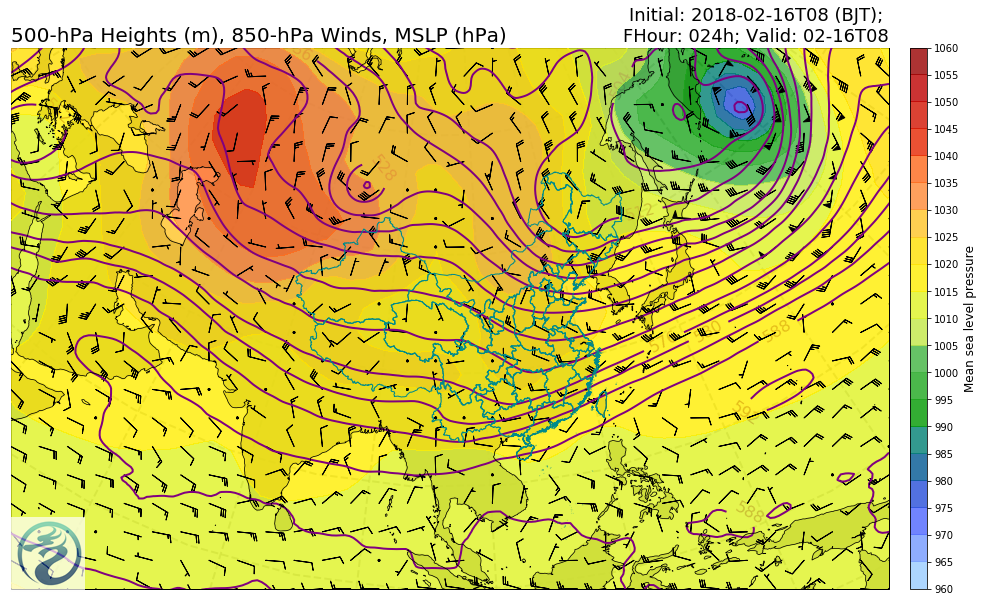

In [37]:
# make weather map

# set data adn plot projection
datacrs = ccrs.PlateCarree()
plotcrs = ccrs.AlbersEqualArea(central_latitude=45., central_longitude=100., standard_parallels=[30., 60.])

# set figure
fig = plt.figure(figsize=(13.8,8))
gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1, .02], bottom=.07, top=.99, hspace=0.01, wspace=0.01)
ax = plt.subplot(gs[0], projection=plotcrs)

# plot backgroud
ax.set_extent([50, 150, 0, 65], crs=datacrs)
ax.add_feature(cfeature.LAND, facecolor='0.6')
ax.coastlines('50m', edgecolor='black', linewidth=0.75, zorder=100)
add_china_map_2cartopy(ax, name='province', edgecolor='darkcyan', lw=1, zorder=100)

# add title
plt.title('500-hPa Heights (m), 850-hPa Winds, MSLP (hPa)',loc='left', fontsize=20)
plt.title('Initial: 2018-02-16T08 (BJT); \nFHour: 024h; Valid: 02-16T08', loc='right', fontsize=18)

# draw mean sea level pressure
x, y = np.meshgrid(mslp_data['lon'], mslp_data['lat'])
clevs = np.arange(960, 1065, 5)
cmap = guide_cmaps(26)
cf = ax.contourf(x, y, ndimage.gaussian_filter(np.squeeze(mslp_data['data']), sigma=1, order=0), 
                 clevs, cmap=cmap, alpha=0.8, zorder=10, transform=datacrs)
cax = plt.subplot(gs[1])
cb = plt.colorbar(cf, cax=cax, orientation='vertical', extendrect='True', ticks=clevs)
cb.set_label('Mean sea level pressure', size=12)

# draw 850hPa wind barbs
x, y = np.meshgrid(u850_data['lon'], u850_data['lat'])
u = np.squeeze(u850_data['data']) * 2.5
v = np.squeeze(v850_data['data']) * 2.5
bb = ax.barbs(x, y, u, v, length=6, regrid_shape=20, transform=datacrs, 
              fill_empty=False, sizes=dict(emptybarb=0.05), zorder=20)

# draw 500hPa geopotential height
x, y = np.meshgrid(gh500_data['lon'], gh500_data['lat'])
clevs = np.append(np.arange(480, 584, 8), np.arange(580, 604, 4))
cs = ax.contour(x, y, ndimage.gaussian_filter(np.squeeze(gh500_data['data']), sigma=1, order=0), 
                clevs, colors='purple', linewidths=2, transform=datacrs, zorder=30)
plt.clabel(cs, inline=1, fontsize=16, fmt='%.0f')

# grid lines
gl = ax.gridlines(crs=datacrs, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mpl.ticker.FixedLocator(np.arange(0,360,15))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(-90,90,15))

# add logo
add_logo(fig, alpha=0.7)

# show figure
gs.tight_layout(fig)
plt.show()